# Phase 3: Advanced - Quantitative Analysis & Alpha Generation

In this phase, we implement a **Quantitative Refinement Loop**. This is a standard professional workflow where agents collaborate to profile data, propose predictive signals (alphas), verify the logic, and finally backtest the performance.

### System Architecture
We use a linear refinement pipeline:
```
Data Profiler → Alpha Builder → Signal Verifier → Backtester Agent → Performance Report
```

| Agent | Role |
|---|---|
| **DataProfiler** | Extracts statistical features (volatility, skew, kurtosis) |
| **AlphaBuilder** | Proposes a mathematical trading signal |
| **SignalVerifier** | Checks for logic errors (overfitting, bias) |
| **BacktesterAgent** | Simulates performance and calculates Sharpe Ratio |

## 1. Environment Setup

In [24]:
%pip install vinagent==0.0.6.post3

from langchain_openai import ChatOpenAI
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv('.env'))

llm = ChatOpenAI(model="gpt-4o-mini")
print("LLM initialized.")

Note: you may need to restart the kernel to use updated packages.
LLM initialized.


## 2. Define Quant State

The `QuantState` tracks the progression from raw data to a verified backtest.

In [25]:
import operator
from typing import Annotated, List, TypedDict

def append_messages(existing: list, update: dict) -> list:
    return existing + [update]

class QuantState(TypedDict):
    """Coherent state for the quantitative refinement loop."""
    # List reducers for automatic merging
    messages: Annotated[list[dict], append_messages]
    data_profile: str
    alpha_signal: str
    verification_report: str
    backtest_metrics: str
    final_report: str

In [26]:
from datetime import datetime
from vinagent.register import primary_function

@primary_function
def get_current_time() -> str:
    """
    Get the current date and time. Use this to know 'today's' date.
    Returns:
        str: Current date and time in YYYY-MM-DD HH:MM:SS format.
    """
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print("Custom time tool defined.")

Custom time tool defined.


In [27]:
import operator
import re
from typing import TypedDict, Annotated, List, Optional, Callable
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from tavily import TavilyClient
from vinagent.register import primary_function

# Define State for DeepSearch
class DeepSearchState(TypedDict):
    task: str
    plan: List[str]
    draft: str
    critique: str
    adjustment: List[str]
    sections: Annotated[List[str], operator.add]
    chapters: Annotated[List[str], operator.add]
    revision_number: int
    max_revisions: int
    max_chapters: int
    max_paragraphs_per_chapter: int
    max_critical_queries: int
    number_of_chapters: int
    current_chapter_order: int

class FlexibleDeepSearch:
    PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an analytical essay on the topic. outline for the user provided topic. Give an outline of the essay along with any relevant notes or instructions for the chapters. Not more than {max_chapters} chapters. The output should be in the following format:\n1. Chapter 1\n2. Chapter 2\n..."""
    WRITER_PROMPT = """You are an researcher assistant tasked with writing excellent {max_paragraphs_per_chapter} paragraph research article. Generate the best research possible for the chapter based on user's collected information. If the user provides critique and suggested adjustment, respond with a revised version of your previous content. Directly generate without any explanation. Utilize all the information below as needed:\n\n------\n- Previous content:\n{content}\n- Critique:\n{critique}\n- Suggested Adjustment:\n{adjustment}"""
    REFLECTION_PROMPT = """You are a teacher grading an research submission. Generate critique and recommendations for the user's submission. Only generate critique and recommendations less than 200 words."""
    RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with critiquing information. Generate a list of search queries that will gather any relevant information. Only generate maximum {max_critical_queries} queries."""

    def __init__(self, llm, search_func: Callable[[str], List[str]]):
        self.llm = llm
        self.search_func = search_func
        self.graph = self._build_graph()

    def _build_graph(self):
        builder = StateGraph(DeepSearchState)
        builder.add_node("planner", self.plan_node)
        builder.add_node("generate", self.generation_node)
        builder.add_node("reflect", self.reflection_node)
        builder.add_node("research_critique", self.research_critique_node)
        builder.add_edge(START, "planner")
        builder.add_edge("planner", "generate")
        builder.add_conditional_edges("generate", self.should_continue, {END: END, "reflect": "reflect"})
        builder.add_edge("reflect", "research_critique")
        builder.add_edge("research_critique", "generate")
        return builder.compile(checkpointer=MemorySaver())

    def plan_node(self, state: DeepSearchState):
        messages = [SystemMessage(content=self.PLAN_PROMPT.format(max_chapters=state['max_chapters'])), HumanMessage(content=state["task"])]
        response = self.llm.invoke(messages)
        list_tasks = [t for t in response.content.split("\n") if re.match(r"^\d+\. ", t.strip())]
        return {"plan": list_tasks, "current_chapter_order": 0, "number_of_chapters": len(list_tasks)}

    def generation_node(self, state: DeepSearchState):
        idx = state["current_chapter_order"]
        chapter_outline = state["plan"][idx]
        chapter_title = chapter_outline.split("\n")[0].strip()
        search_results = self.search_func(chapter_outline)
        if state.get("adjustment"): search_results.extend(state["adjustment"])
        messages = [SystemMessage(content=self.WRITER_PROMPT.format(max_paragraphs_per_chapter=state["max_paragraphs_per_chapter"], content="\n".join(search_results), critique=state.get("critique", ""), adjustment="\n".join(state.get("adjustment", [])))), HumanMessage(content=f"Outline: {chapter_outline}")]
        response = self.llm.invoke(messages)
        is_last_revision = state.get("revision_number", 1) >= state["max_revisions"]
        new_data = {"draft": response.content, "sections": [chapter_title]}
        if is_last_revision:
            new_data["chapters"] = [f"## {chapter_title}\n{response.content}"]
            new_data["current_chapter_order"] = idx + 1
            new_data["revision_number"] = 1
        else:
            new_data["revision_number"] = state["revision_number"] + 1
        return new_data

    def reflection_node(self, state: DeepSearchState):
        messages = [SystemMessage(content=self.REFLECTION_PROMPT), HumanMessage(content=state["draft"])]
        response = self.llm.invoke(messages)
        return {"critique": response.content}

    def research_critique_node(self, state: DeepSearchState):
        messages = [SystemMessage(content=self.RESEARCH_CRITIQUE_PROMPT.format(max_critical_queries=state["max_critical_queries"])), HumanMessage(content=f"Critique to address: {state['critique']}")]
        response = self.llm.invoke(messages)
        queries = [q for q in response.content.split("\n") if re.match(r"^\d+\. ", q.strip())]
        new_results = []
        for q in queries: new_results.extend(self.search_func(q))
        return {"adjustment": new_results}

    def should_continue(self, state: DeepSearchState):
        if state["current_chapter_order"] >= state["number_of_chapters"]: return END
        return "reflect"

    def run(self, query: str, config: dict = {}):
        initial_state = {"task": query, "max_chapters": config.get("max_chapters", 3), "max_paragraphs_per_chapter": config.get("max_paragraphs_per_chapter", 3), "max_critical_queries": config.get("max_critical_queries", 3), "max_revisions": config.get("max_revisions", 1), "revision_number": 1, "sections": [], "chapters": [], "adjustment": []}
        final_state = self.graph.invoke(initial_state, {"configurable": {"thread_id": "custom_deepsearch"}})
        return f"# I. Planning\n" + "\n".join(final_state["sections"]) + "\n\n# II. Results\n" + "\n\n".join(final_state["chapters"])

tavily = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

def tavily_search(query: str) -> List[str]:
    response = tavily.search(query=query, max_results=3)
    return [r["content"] for r in response["results"]]

@primary_function
def custom_deepsearch_tool(query: str, max_chapters: int = 1, max_paragraphs_per_chapter: int = 3, max_critical_queries: int = 3, max_revisions: int = 1) -> str:
    """Invoke custom deepsearch to deeply analyze the query and generate a more detailed response."""
    openai_llm = ChatOpenAI(model="gpt-4o-mini")
    deepsearch = FlexibleDeepSearch(llm=openai_llm, search_func=tavily_search)
    return deepsearch.run(query, config={"max_chapters": max_chapters, "max_paragraphs_per_chapter": max_paragraphs_per_chapter, "max_critical_queries": max_critical_queries, "max_revisions": max_revisions})

print("Custom DeepSearch tool defined.")

Custom DeepSearch tool defined.


## 3. Implement Quantitative Agents

Each agent adds scientific rigor to the signal generation process.

In [28]:
from vinagent.multi_agent import AgentNode
from vinagent.logger.logger import logging_message

class DataProfiler(AgentNode):
    """Analyzes statistical properties of the asset."""
    @logging_message
    def exec(self, state: QuantState) -> dict:
        print(f"[{self.name}] Analyzing market data and profiling distributions...")
        symbol = state.get("symbol", "NVDA")
        prompt = f"Profile the statistical behavior of {symbol} over the last 2 years. Identify volatility regimes and return distribution trends."
        output = self.invoke(prompt)
        return {
            "messages": {"role": "Profiler", "content": output.content if hasattr(output, "content") else str(output) if hasattr(output, "content") else str(output)},
            "data_profile": output.content if hasattr(output, "content") else str(output) if hasattr(output, "content") else str(output)
        }

class AlphaBuilder(AgentNode):
    """Proposes mathematical alpha signals based on data profiles."""
    """Proposes a mathematical signal based on the data profile."""
    @logging_message
    def exec(self, state: QuantState) -> dict:
        print(f"[{self.name}] Analyzing market data and profiling distributions...")
        profile = state.get("data_profile", "")
        prompt = f"Based on this data profile: \n{profile}\n\nPropose a specific trading alpha signal (momentum, mean-reversion, etc.). Define the logic clearly."
        output = self.invoke(prompt)
        return {
            "messages": {"role": "AlphaBuilder", "content": output.content if hasattr(output, "content") else str(output) if hasattr(output, "content") else str(output)},
            "alpha_signal": output.content if hasattr(output, "content") else str(output) if hasattr(output, "content") else str(output)
        }

class SignalVerifier(AgentNode):
    """Challenges the logic to prevent overfitting."""
    @logging_message
    def exec(self, state: QuantState) -> dict:
        print(f"[{self.name}] Analyzing market data and profiling distributions...")
        signal = state.get("alpha_signal", "")
        prompt = f"Validate this alpha signal for common hedge fund pitfalls like look-ahead bias and overfitting: \n{signal}\n\nProvide a verification report."
        output = self.invoke(prompt)
        return {
            "messages": {"role": "Verifier", "content": output.content if hasattr(output, "content") else str(output) if hasattr(output, "content") else str(output)},
            "verification_status": output.content if hasattr(output, "content") else str(output) if hasattr(output, "content") else str(output)
        }

class BacktesterAgent(AgentNode):
    """Simulates the signal and provides Sharpe/Drawdown metrics."""
    @logging_message
    def exec(self, state: QuantState) -> dict:
        print(f"[{self.name}] Analyzing market data and profiling distributions...")
        signal = state.get("alpha_signal", "")
        prompt = f"Simulate the performance of this signal: \n{signal}\n\nProvide estimated Sharpe Ratio, Max Drawdown, and Annualized Return."
        output = self.invoke(prompt)
        return {
            "messages": {"role": "Backtester", "content": output.content if hasattr(output, "content") else str(output) if hasattr(output, "content") else str(output)},
            "backtest_results": output.content if hasattr(output, "content") else str(output) if hasattr(output, "content") else str(output)
        }

## 4. Assemble the Refinement Pipeline

We use a linear sequential flow to ensure each agent builds upon the previous's work.

In [29]:
from vinagent.register import primary_function
from typing import Any, Union, Callable, List
import time
import re
import operator
from typing import Annotated, TypedDict
from IPython.display import display, Markdown

# Tools imported directly
from vinagent.tools.yfinance_tools import fetch_stock_data, visualize_stock_data, plot_returns
from vinagent.tools.websearch_tools import search_api

@primary_function
def get_current_time() -> str:
    """Get current system time."""
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print("Core Infrastructure Initialized (Direct Registration).")

Resilient tool infrastructure initialized.


In [30]:
from vinagent.multi_agent import CrewAgent
from vinagent.graph.operator import FlowStateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# 1. Modular Agent Setup
instr = "CRITICAL: Format tool arguments as JSON object. NEVER use plain strings."
profiler = DataProfiler(name="profiler", llm=llm, tools=[], instruction=instr)
builder = AlphaBuilder(name="builder", llm=llm, instruction=instr)
verifier = SignalVerifier(name="verifier", llm=llm, tools=[], instruction=instr)
backtester = BacktesterAgent(name="backtester", llm=llm, instruction='Return backtest metrics as clear markdown.')

# 2. Direct Tool Registration
global_tools = [
    primary_function(fetch_stock_data), 
    primary_function(visualize_stock_data), 
    primary_function(plot_returns), 
    primary_function(search_api), 
    get_current_time
]
for agent in [profiler, builder, verifier, backtester]:
    for tool in global_tools:
        agent.tools_manager.register_function_tool(tool)

# 3. Pipeline Assembly
crew = CrewAgent(
    llm=llm,
    checkpoint=MemorySaver(),
    graph=FlowStateGraph(QuantState),
    flow=[
        START >> profiler,
        profiler >> builder,
        builder >> verifier,
        verifier >> backtester,
        backtester >> END
    ]
)
print("Quantitative Refinement Crew Assembled with direct tool registration.")

INFO:vinagent.register.tool:Registered tool: fetch_stock_data (runtime)
INFO:vinagent.register.tool:Registered tool: visualize_stock_data (runtime)
INFO:vinagent.register.tool:Registered tool: plot_returns (runtime)
INFO:vinagent.register.tool:Registered tool: search_api (runtime)
INFO:vinagent.register.tool:Registered tool: custom_deepsearch_tool (runtime)
INFO:vinagent.register.tool:Registered tool: get_current_time (runtime)
INFO:vinagent.register.tool:Registered tool: fetch_stock_data (runtime)
INFO:vinagent.register.tool:Registered tool: visualize_stock_data (runtime)
INFO:vinagent.register.tool:Registered tool: plot_returns (runtime)
INFO:vinagent.register.tool:Registered tool: search_api (runtime)
INFO:vinagent.register.tool:Registered tool: custom_deepsearch_tool (runtime)
INFO:vinagent.register.tool:Registered tool: get_current_time (runtime)
INFO:vinagent.register.tool:Registered tool: fetch_stock_data (runtime)
INFO:vinagent.register.tool:Registered tool: visualize_stock_dat

Quantitative Refinement Crew Assembled with Global Resilient Tools.


## 5. Run the Search for Alpha

Let's target AMZN for signal discovery.

INFO:vinagent.multi_agent.crew:No authentication card provided, skipping authentication
INFO:vinagent.agent.agent:No authentication card provided, skipping authentication
INFO:vinagent.agent.agent:I'am chatting with unknown_user
INFO:vinagent.agent.agent:Tool calling iteration 1/10


{'input': {'messages': {'role': 'user', 'content': 'Find a momentum-based alpha for AMZN.'}}, 'config': {'configurable': {'user_id': 'admin'}, 'thread_id': 3}}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:Executing tool call: {'tool_name': 'fetch_stock_data', 'tool_type': 'function', 'arguments': {'symbol': 'NVDA', 'start_date': '2021-10-01', 'end_date': '2023-10-01', 'interval': '1d'}, 'module_path': '__runtime__'}
INFO:vinagent.register.tool:Completed executing function tool fetch_stock_data({'symbol': 'NVDA', 'start_date': '2021-10-01', 'end_date': '2023-10-01', 'interval': '1d'})
INFO:vinagent.agent.agent:Tool calling iteration 2/10
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:Executing tool call: {'tool_name': 'plot_returns', 'tool_type': 'function', 'arguments': {'symbol': 'NVDA', 'start_date': '2021-10-01', 'end_date': '2023-10-01', 'interval': '1d'}, 'module_path': '__runtime__'}
INFO:vinagent.register.tool:Completed executing function tool plot_returns({'symbol': 'NVDA', 'start_date': '2021-1

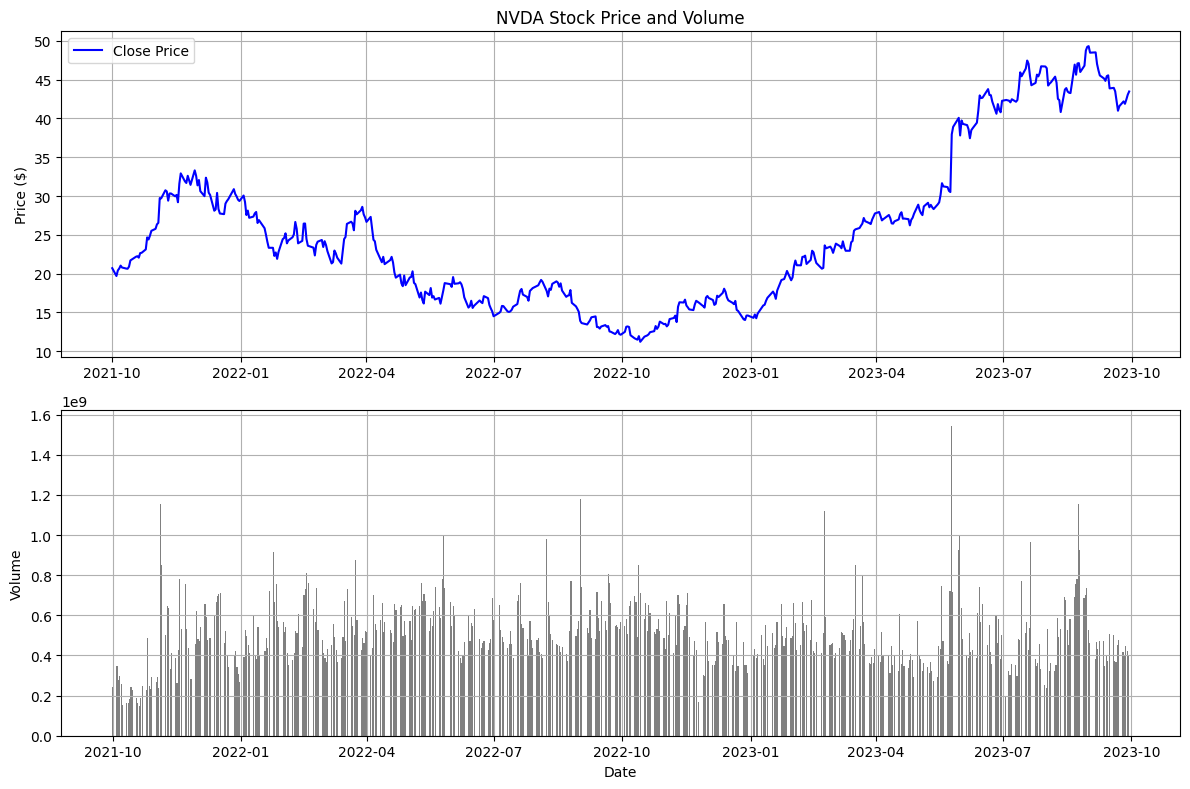

INFO:vinagent.register.tool:Completed executing function tool visualize_stock_data({'symbol': 'NVDA', 'start_date': '2021-10-01', 'end_date': '2023-10-01', 'interval': '1d'})
INFO:vinagent.agent.agent:Tool calling iteration 4/10
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:Executing tool call: {'tool_name': 'custom_deepsearch_tool', 'tool_type': 'function', 'arguments': {'query': 'Profile the statistical behavior of NVDA over the last 2 years. Identify volatility regimes and return distribution trends.', 'max_chapters': 3, 'max_paragraphs_per_chapter': 5, 'max_critical_queries': 2, 'max_revisions': 1}, 'module_path': '__runtime__'}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP

BadRequestError: Error code: 400 - {'error': {'message': "Invalid parameter: messages with role 'tool' must be a response to a preceeding message with 'tool_calls'.", 'type': 'invalid_request_error', 'param': 'messages.[0].role', 'code': None}}

In [31]:
initial_state = {"symbol": "AMZN"}
result = crew.invoke(query="Find a momentum-based alpha for AMZN.", user_id='admin', thread_id=3)

print("\n--- FINAL QUANT REPORT ---\n")
print(result["backtest_results"])